# **Skin Disease Recognition**


* Project Overview
  
This project is aimed at developing a robust skin disease recognition system. The project involves the recognition and classification of skin disease.
* Dataset
  
We used the Dermnet dataset, which contains different labelled skin disease images for training and testing our model. The dataset includes 23 types of skin diseases, including acne, melanoma, Eczema, Seborrheic Keratoses, Tinea Ringworm, Bullous disease, Poison Ivy, Psoriasis, Vascular Tumors, etc. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

## Outline
1. [Initialization and Helper functions](#Initialization-and-Helper-functions)
2. [Chapter 1: Data Preprocessing](#Chapter-1:-Data-Preprocessing)
   - [1.1 Implement the Custom Dataset](#1.3-Implement-the-Custom-Dataset)
   - [1.2 Data Augmentation](#1.2-Data-Augmentation)
   - [1.3 Creation of Data Loader](#1.3-Creation-of-Data-Loader)
3. [Chapter 2: Fine Tune the Pretrained Models](#Chapter-2:-Fine-Tune-the-Pretrained-Models)
4. [Chapter 3: Model Loading](#Chapter-3:-Model-Loading)
5. [Chapter 4: Model Testing](#Chapter-4:-Model-Testing)
6. [Chapter 5: Model Evaluation](#Chapter-5:-Model-Evaluation)
7. [Chapter 6: Inferences](#Chapter-6:-Inferences)

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import (
    densenet121, mobilenet_v2, efficientnet_b3, DenseNet121_Weights, MobileNet_V2_Weights, EfficientNet_B3_Weights
)

import matplotlib.pyplot as plt
import numpy as np


import kagglehub
import os
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
from safetensors.torch import save_file, load_file
# from kaggle_secrets import UserSecretsClient
import wandb


from safetensors.torch import save_file, load_file
from collections import Counter  # Added
import json

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns
from typing import Tuple, Dict, List
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random


### Initialization and Helper functions

In [2]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'dl.ipynb' 
status = wandb.login(key='78fdef8c508ef3b1b92f66345a383b486d6b36f3')
if (status):
     print('Successfully logged into W&B')
else:
     print('Unable to log into W&B')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kehyi\_netrc
wandb: Currently logged in as: kehyiqian (kehyiqian-universiti-tunku-abdul-rahman) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Successfully logged into W&B


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def save_model_and_history(model, history, save_dir="checkpoints", model_name="model", epoch=None):
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model weights
    model_path = os.path.join(save_dir, f"{model_name}_weights.pth")
    torch.save(model.state_dict(), model_path)

    # Save training history
    history_path = os.path.join(save_dir, f"{model_name}_history.json")
    with open(history_path, "w") as f:
        json.dump(history, f)

    print(f"Model saved to: {model_path}")
    print(f"History saved to: {history_path}")

In [5]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def train_one_epoch(epoch, model, train_loader, criterion, optimizer, device="cuda", log_step=20, mixup_alpha=0.1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply Mixup Augmentation
        '''
        From GrokAI
        Mixup creates synthetic training examples by blending two images and their labels, 
        which can improve generalization and handle class imbalance better.
        '''
        if mixup_alpha > 0:
            lam = np.random.beta(mixup_alpha, mixup_alpha)
            rand_index = torch.randperm(inputs.size(0)).to(device)
            inputs = lam * inputs + (1 - lam) * inputs[rand_index]
            labels_a, labels_b = labels, labels[rand_index]
        else:
            labels_a = labels_b = labels
            lam = 1.0

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        

        # For metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (lam * predicted.eq(labels_a).sum().item() + (1 - lam) * predicted.eq(labels_b).sum().item())
        total += labels.size(0)

        if i % log_step == 0 or i == len(train_loader) - 1:
            print(f"[Epoch {epoch+1}, Step {i+1}] train_loss: {running_loss / (i + 1):.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    return train_loss, train_acc


In [6]:
############################ 
#Adapted from practical 7 but changed a bit
############################ 

def evaluate(model, test_loader, criterion, device="cuda"):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss += loss.item() * inputs.size(0)  # scale loss by batch size
    test_loss /= total
    test_acc = 100 * correct / total

    return test_loss, test_acc

In [7]:
############################ 
# Coded by grokAI
############################ 

#Address Class Imbalance #Focal Loss will focus on hard examples, particularly minority classes, improving overall Test Accuracy. #added label smoothing
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.1):   #high gamma may over-focus on hard examples, causing fluctuations.smoothen testloss and generalisation
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none', label_smoothing=self.label_smoothing)(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [8]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def train(model, optimizer, criterion, train_loader, test_loader, config, device="cuda", model_name="model"):

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
   
    best_acc = 0
    patience = 7
    patience_counter = 0

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(config['num_epochs']):
        train_loss, train_acc = train_one_epoch(epoch, model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(test_loss)
        history['val_acc'].append(test_acc)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "validation_loss": test_loss,
            "validation_acc": test_acc,
            "lr_backbone": optimizer.param_groups[0]['lr'],
            "lr_classifier": optimizer.param_groups[1]['lr']
        })


        print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.2f}%, Train Loss: {train_loss:.4f}, Validation Acc: {test_acc:.2f}%, Validation Loss: {test_loss:.4f}")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
            save_file(model.state_dict(), f"best_model_epoch_{epoch+1}.safetensors")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step(test_loss)

    save_model_and_history(model, history, model_name=model_name)
        

In [9]:

############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def build_model(model_name, num_classes, config, device='cuda', return_optimizer=True):
    # Select model
    ############################ 
    # Coded by Keh Yi Qian
    ############################ 
    if model_name == 'densenet':
        model = densenet121(weights=config['weights']).to(device)
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        ).to(device)
    ############################ 
    # Coded by Gooi Yong Shen
    ############################ 
    elif model_name == 'mobilenet':
        model = mobilenet_v2(weights=config['weights']).to(device)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        ).to(device)
    ############################ 
    # Coded by Kok Tze Kang
    ############################ 
    elif model_name == 'efficientnet':
        model = efficientnet_b3(weights=config['weights']).to(device)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.65),
            nn.Linear(in_features, num_classes)
        ).to(device)
    else:
        raise ValueError("Unsupported model name")

    # Finetuning strategy
    finetuned_layers = config.get('finetuned_layers', 'all')

    if finetuned_layers == 'classifier':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif finetuned_layers == 'features_last' and model_name == 'efficientnet':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.features[-1].parameters():
            param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif finetuned_layers == 'all':
        for param in model.parameters():
            param.requires_grad = True
    else:
        for name, param in model.named_parameters():
            if not any(name.startswith(layer) for layer in config['finetuned_layers']):
                param.requires_grad = False

    # Print model info
    print(f"Model           : {model_name}")
    print(f"Weights         : {config['weights']}")
    print(f"Finetuned layers: {finetuned_layers}\n")

    # Optimizer
    if not return_optimizer:
        return model

    if hasattr(model, 'features') and hasattr(model, 'classifier'):
        optimizer = torch.optim.AdamW([
            {"params": model.features.parameters(), "lr": config.get("backbone_lr",config['lr_features'])},
            {"params": model.classifier.parameters(), "lr": config.get("classifier_lr",config['lr_classifier'])}
        ], weight_decay=config.get("weight_decay", 1e-3))
    else:
        raise ValueError("Model must have 'features' and 'classifier' attributes.")

  

    return model, optimizer


### Chapter 1: Data Preprocessing

In [10]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

path = kagglehub.dataset_download("shubhamgoel27/dermnet") # directly download the dataset from kaggle
dataset_path = os.listdir(path)

train_path = os.path.join(path, 'train')   #train folder
test_path = os.path.join(path, 'test')     #test folder
# List class names from the 'train' folder
class_names = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]
num_classes = len(class_names)
print(f'Class names found in the training set: \n{class_names} \n')
print(f'{num_classes = } \n')

class_names = [folder for folder in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, folder))]
num_classes = len(class_names)
print(f'Class names found in the testing set: \n{class_names} \n')
print(f'{num_classes = } \n')

Class names found in the training set: 
['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections'] 

num_classes = 23 

Class names found in the test

#### 1.1 Implement the Custom Dataset

In [11]:
############################ 
#Adapted from practical 7 but changed a bit
############################ 

class SkinDiseaseDataset(Dataset):
    def __init__(self, path, transform=None, selected_classes=None):
        self.path = path
        self.transform = transform
        self.classes = []            # filtered class folder names
        self.class_to_idx = {}       # mapping: class name -> label index
        self.images_path = []
        self.targets = []

        for i, cls in enumerate(sorted(os.listdir(path))):
            if selected_classes is not None and cls not in selected_classes:
                continue
            self.classes.append(cls)
            self.class_to_idx[cls] = len(self.class_to_idx)  # re-index
            cls_path = os.path.join(path, cls)
            for filename in os.listdir(cls_path):
                file_path = os.path.join(cls_path, filename)
                self.images_path.append(file_path)
                self.targets.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.targets[idx]
        return image, label


#### 1.2 Data Augmentation

In [12]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

transform_train = v2.Compose([
    v2.ToImage(), # Convert input to PIL Image if needed
    v2.Resize((224,224)), # Resize to 224x224
    v2.RandomHorizontalFlip(), # Randomly flip horizontally
    v2.RandomVerticalFlip(p=0.5),  # Added vertical flip
    v2.RandomRotation(degrees=10), # Randomly rotate the image by up to 10 degrees
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Soften color jitter
    v2.ToDtype(torch.float32, scale=True), # Scale to [0,1] and make float32
    v2.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225]),# Normalization
])

transform_test = v2.Compose([
    v2.ToImage(),                         
    v2.Resize((224,224)),                 
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

train_dataset = SkinDiseaseDataset(train_path, transform_train)
test_dataset = SkinDiseaseDataset(test_path, transform_test)


In [14]:

############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(train_dataset.images_path, train_dataset.targets))

print('Number of training samples:', len(train_idx), "| indices:", train_idx)
print('Number of val samples     :', len(val_idx), "| indices:", val_idx)

Number of training samples: 12445 | indices: [ 8880 14613  9269 ... 14918  1808  2715]
Number of val samples     : 3112 | indices: [  474 14781   392 ...  8378 10909  8603]


In [15]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

### 1.3 Creation of Data Loader

In [16]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

x_batch, y_batch = next(iter(train_loader))
print(f'{x_batch.shape = }')
print(f'{y_batch.shape = }')


x_batch.shape = torch.Size([32, 3, 224, 224])
y_batch.shape = torch.Size([32])


### Chapter 2: Fine Tune the Pretrained Models

### Computes smoothed class-balanced weights based on training data distribution and applies them to the Focal Loss to improve generalization and handle class imbalance.

In [18]:
############################ 
# Coded by grokAI
############################ 

# use class weights to distru
# Compute class weights
def check_class_distribution(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    print("Class distribution:")
    for class_idx, count in class_counts.items():
        class_name = class_names[class_idx]
        print(f"{class_name}: {count} samples")
    return class_counts

class_counts = check_class_distribution(train_dataset)
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (num_classes * class_counts[i]) for i in range(num_classes)], dtype=torch.float32)
smoothing_factor = 0.5
uniform_weights = torch.ones(num_classes, dtype=torch.float32)
class_weights = smoothing_factor * class_weights + (1 - smoothing_factor) * uniform_weights         #Label smoothing can prevent the model from becoming overconfident, improving generalization.
class_weights = class_weights.to(device)


# Update loss function with class weights
loss_function = FocalLoss(alpha=class_weights, gamma=3.0, reduction='mean', label_smoothing=0.1)   #label smoothing


Class distribution:
Acne and Rosacea Photos: 840 samples
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 1149 samples
Atopic Dermatitis Photos: 489 samples
Bullous Disease Photos: 448 samples
Cellulitis Impetigo and other Bacterial Infections: 288 samples
Eczema Photos: 1235 samples
Exanthems and Drug Eruptions: 404 samples
Hair Loss Photos Alopecia and other Hair Diseases: 239 samples
Herpes HPV and other STDs Photos: 405 samples
Light Diseases and Disorders of Pigmentation: 568 samples
Lupus and other Connective Tissue diseases: 420 samples
Melanoma Skin Cancer Nevi and Moles: 463 samples
Nail Fungus and other Nail Disease: 1040 samples
Poison Ivy Photos and other Contact Dermatitis: 260 samples
Psoriasis pictures Lichen Planus and related diseases: 1405 samples
Scabies Lyme Disease and other Infestations and Bites: 431 samples
Seborrheic Keratoses and other Benign Tumors: 1371 samples
Systemic Disease: 606 samples
Tinea Ringworm Candidiasis and other Fungal Infec

In [19]:
############################ 
# Coded by Keh Yi Qian
############################ 

model_type = 'densenet'
model_name = 'model_densenet'
config =  {
    'weights'         : 'IMAGENET1K_V1',
    'finetuned_layers': 'all',
    'lr_features'     : 1e-4,
    'lr_classifier'   : 5e-4,
    'num_epochs'      : 30
}

In [20]:
############################ 
# Coded by Keh Yi Qian
############################ 
wandb.init(
    project='DL_groupAssigment',
    name='densenet_train',
    config =  {
    'weights'         : 'IMAGENET1K_V1',
    'finetuned_layers': 'all',
    'lr_features'     : 1e-4,
    'lr_classifier'   : 5e-4,
    'num_epochs'      : 30
    },
)

In [ ]:
############################ 
# Coded by Keh Yi Qian
############################ 

model, optimizer = build_model(model_type, num_classes, config, device)
train(model, optimizer, loss_function, train_loader, val_loader, config, device, model_name = model_name)

Model           : densenet
Weights         : IMAGENET1K_V1
Finetuned layers: all

[Epoch 1, Step 1] train_loss: 2.7317
[Epoch 1, Step 21] train_loss: 2.7235
[Epoch 1, Step 41] train_loss: 2.7007
[Epoch 1, Step 61] train_loss: 2.6569
[Epoch 1, Step 81] train_loss: 2.6234
[Epoch 1, Step 101] train_loss: 2.5825
[Epoch 1, Step 121] train_loss: 2.5406
[Epoch 1, Step 141] train_loss: 2.5123
[Epoch 1, Step 161] train_loss: 2.4867
[Epoch 1, Step 181] train_loss: 2.4694
[Epoch 1, Step 201] train_loss: 2.4505
[Epoch 1, Step 221] train_loss: 2.4250
[Epoch 1, Step 241] train_loss: 2.4121
[Epoch 1, Step 261] train_loss: 2.4051
[Epoch 1, Step 281] train_loss: 2.3997
[Epoch 1, Step 301] train_loss: 2.3821
[Epoch 1, Step 321] train_loss: 2.3636
[Epoch 1, Step 341] train_loss: 2.3518
[Epoch 1, Step 361] train_loss: 2.3422
[Epoch 1, Step 381] train_loss: 2.3291
[Epoch 1, Step 389] train_loss: 2.3252
[Epoch 1] Train Acc: 24.54%, Train Loss: 2.3252, Validation Acc: 36.18%, Validation Loss: 0.0688
[Epoch 2

In [22]:
wandb.finish()

In [95]:
#####################
# Coded by Gooi Yong Shen
########################

# In GooiYongShen_MobileNet.ipynb

In [ ]:
#####################
# Coded by Kok Tze Kang
########################

model_type = 'efficientnet'
model_name = 'model_efficientnet'
config =  {
    'weights'         : 'IMAGENET1K_V1',
    'finetuned_layers': 'all',
    'lr_features'     : 1e-4,
    'lr_classifier'   : 5e-4,
    'num_epochs'      : 30
}

In [ ]:
############################ 
# Coded by Kok Tze Kang
############################ 

wandb.init(
    project='DL_groupAssigment',
    name='All - output- EfficientNet_B3',
    config =  {
    'weights'         : 'IMAGENET1K_V1',
    'finetuned_layers': 'all',
    'lr_features'     : 1e-4,
    'lr_classifier'   : 5e-4,
    'num_epochs'      : 30
    },
)

In [ ]:
############################ 
# Coded by Kok Tze Kang
############################ 

model, optimizer = build_model(model_type, num_classes, config, device)
train(model, optimizer, loss_function, train_loader, val_loader, config, device, model_name = model_type)

In [ ]:
############################ 
# Coded by Kok Tze Kang
############################ 

wandb.finish()

### Chapter 3: Model Loading

In [23]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 


def load_model(model_name: str, num_classes: int, weights_path: str, device: str) -> nn.Module:
    if model_name == 'densenet':
        model = models.densenet121(weights=None)
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    elif model_name == 'mobilenet':
        model = models.mobilenet_v2(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )
    elif model_name == 'efficientnet':
        model = models.efficientnet_b3(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.65),
            nn.Linear(in_features, num_classes)
        )
    else:
        raise ValueError("Unsupported model type")

    model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))

    return model.to(device)

### Load DenseNet Model

In [76]:
import importlib
models = importlib.reload(torchvision.models)


In [77]:
model_densnet = load_model(model_name='densenet', num_classes= num_classes, weights_path='checkpoints/model_densenet_weights.pth', device=device)

### Load MobileNet Model

In [78]:
model_mobilenet = load_model(model_name='mobilenet', num_classes= num_classes, weights_path='checkpoints/model_mobilenet_weights.pth', device=device)

### Load EfficientNet Model

In [79]:
model_efficientnet = load_model(model_name='efficientnet', num_classes= num_classes, weights_path='checkpoints/efficientnet_weights.pth', device=device)

### Load History （Optional if needed)

In [25]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def load_history_json(history_path: str) -> Dict:
    with open(history_path, 'r') as f:
        history = json.load(f)
    return history

### Load history of DenseNet Model

In [82]:
history_densenet = load_history_json('checkpoints/model_densenet_history.json')

### Load history of MobileNet Model

In [83]:
history_mobilenet = load_history_json('checkpoints/model_mobilenet_history.json')

### Load history of EfficientNet Model

In [84]:
history_efficientnet = load_history_json('checkpoints/history.json')

### Evaluation of Comparison of Validation and Training data

In [93]:
import matplotlib.pyplot as plt

def plot_model_comparison(history_dicts, model_names):
    colors = ['r', 'g', 'b']  # One color per model

    plt.figure(figsize=(14, 10))

    # 1. Training Loss
    plt.subplot(2, 2, 1)
    #Due to the training method differences in the EfficientNet Model, the first six epochs are the loss is so that the line starts with epochs 7
    for history, name, color in zip(history_dicts, model_names, colors): 
        offset = 1
        if name.lower().startswith("efficient"):
            offset = 7  # Adjust if EfficientNet starts at epoch 7
        epochs = range(offset, offset + len(history['train_loss']))
        plt.plot(epochs, history['train_loss'], color=color, label=name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Validation Loss
    plt.subplot(2, 2, 2)
    for history, name, color in zip(history_dicts, model_names, colors):
        offset = 1
        if name.lower().startswith("efficient"):
            offset = 7
        epochs = range(offset, offset + len(history['val_loss']))
        plt.plot(epochs, history['val_loss'], color=color, label=name)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 3. Training Accuracy
    plt.subplot(2, 2, 3)
    for history, name, color in zip(history_dicts, model_names, colors):
        offset = 1
        if name.lower().startswith("efficient"):
            offset = 7
        epochs = range(offset, offset + len(history['train_acc']))
        plt.plot(epochs, history['train_acc'], color=color, label=name)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 4. Validation Accuracy
    plt.subplot(2, 2, 4)
    for history, name, color in zip(history_dicts, model_names, colors):
        offset = 1
        if name.lower().startswith("efficient"):
            offset = 7
        epochs = range(offset, offset + len(history['val_acc']))
        plt.plot(epochs, history['val_acc'], color=color, label=name)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


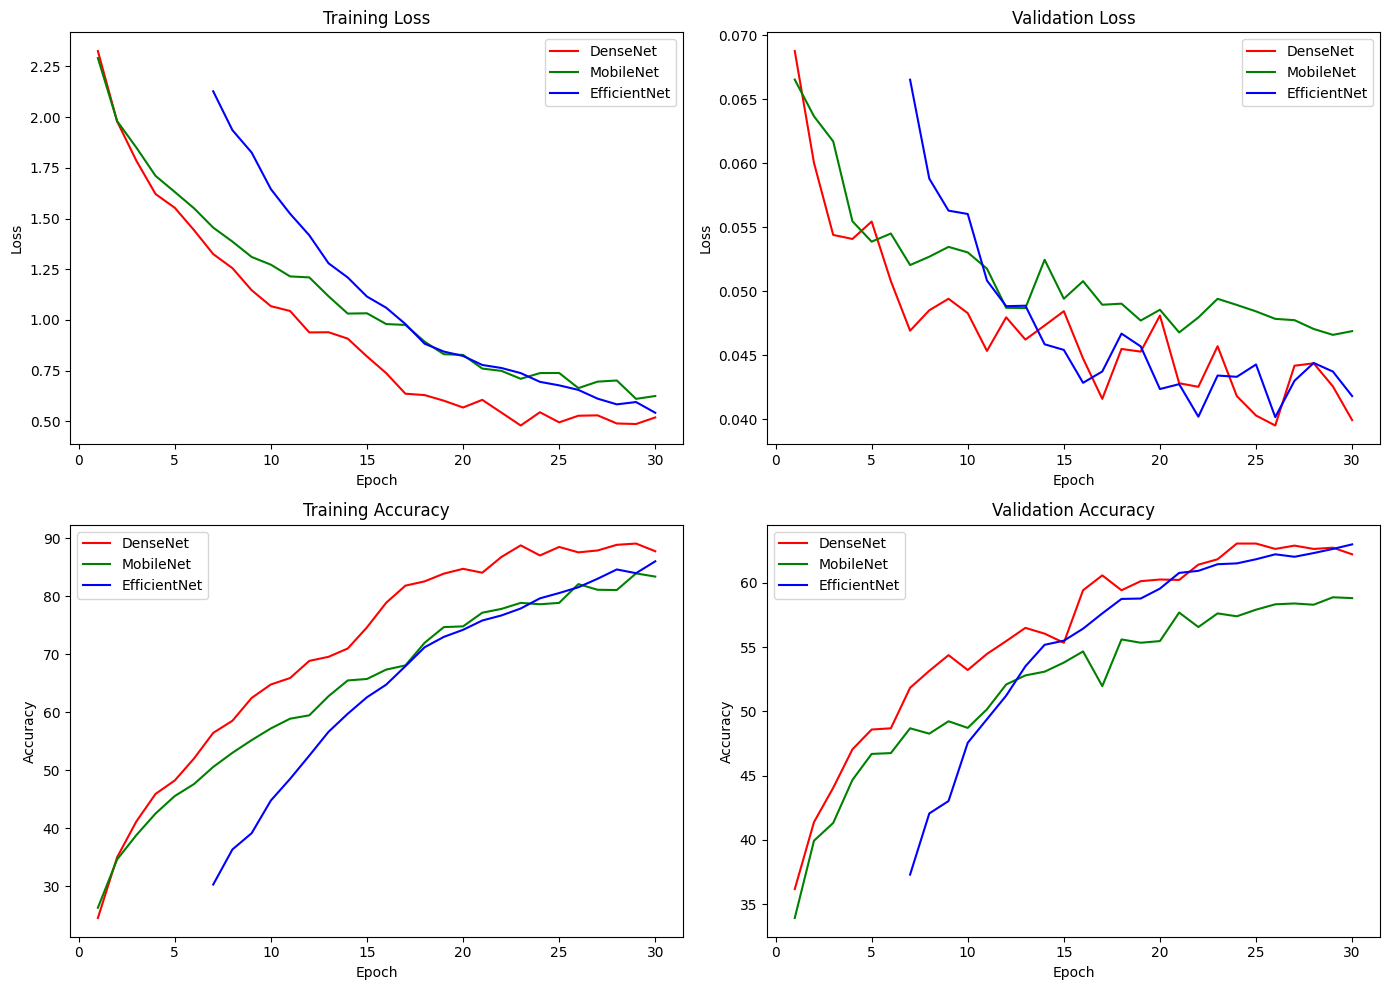

In [94]:
plot_model_comparison(
    history_dicts=[history_densenet, history_mobilenet, history_efficientnet],
    model_names=["DenseNet", "MobileNet", "EfficientNet"]
)


### Chapter 4: Model Testing

### Testing the DenseNet Model with test_loader

In [27]:
test_loss, test_acc = evaluate(model_densenet, test_loader, loss_function, device)
print(f"Loaded Model Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.2f}%")

Loaded Model Test Loss: 0.038, Test Accuracy: 63.59%


### Testing the MobileNet Model with test_loader

In [44]:
test_loss, test_acc = evaluate(model_mobilenet, test_loader, loss_function, device)
print(f"Loaded Model Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.2f}%")

Loaded Model Test Loss: 0.042, Test Accuracy: 61.62%


### Testing the EfficientNet Model with test_loader

In [45]:
test_loss, test_acc = evaluate(model_efficientnet, test_loader, loss_function, device)
print(f"Loaded Model Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.2f}%")

Loaded Model Test Loss: 0.038, Test Accuracy: 63.92%


### Chapter 5: Model Evaluation

### Evaluation by Classification Report

In [28]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def get_classification_report(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
    return report


### Classification Report of DenseNet Model

In [29]:
report = get_classification_report(model_densenet, test_loader, class_names, device)
print(report)

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos      0.818     0.907     0.860       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions      0.715     0.601     0.653       288
                                          Atopic Dermatitis Photos      0.568     0.610     0.588       123
                                            Bullous Disease Photos      0.570     0.504     0.535       113
                Cellulitis Impetigo and other Bacterial Infections      0.438     0.479     0.458        73
                                                     Eczema Photos      0.634     0.680     0.656       309
                                      Exanthems and Drug Eruptions      0.432     0.535     0.478       101
                 Hair Loss Photos Alopecia and other Hair Diseases      0.536     0.750     0.625        60
                           

### Classification Report of MobileNet Model

In [46]:
report = get_classification_report(model_mobilenet, test_loader, class_names, device)
print(report)

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos      0.835     0.878     0.856       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions      0.681     0.594     0.635       288
                                          Atopic Dermatitis Photos      0.512     0.667     0.580       123
                                            Bullous Disease Photos      0.607     0.478     0.535       113
                Cellulitis Impetigo and other Bacterial Infections      0.491     0.384     0.431        73
                                                     Eczema Photos      0.647     0.563     0.602       309
                                      Exanthems and Drug Eruptions      0.407     0.495     0.446       101
                 Hair Loss Photos Alopecia and other Hair Diseases      0.482     0.667     0.559        60
                           

### Classification Report of EfficientNet Model

In [47]:
report = get_classification_report(model_efficientnet, test_loader, class_names, device)
print(report)

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos      0.793     0.923     0.853       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions      0.688     0.681     0.684       288
                                          Atopic Dermatitis Photos      0.547     0.610     0.577       123
                                            Bullous Disease Photos      0.565     0.540     0.552       113
                Cellulitis Impetigo and other Bacterial Infections      0.403     0.397     0.400        73
                                                     Eczema Photos      0.707     0.602     0.650       309
                                      Exanthems and Drug Eruptions      0.583     0.554     0.569       101
                 Hair Loss Photos Alopecia and other Hair Diseases      0.424     0.600     0.497        60
                           

### Evaluation by Precision-Recall Graph between Three Models

In [49]:
############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def precision_recall_graph(models_dict, test_loader, class_names, device):

    plt.figure(figsize=(10, 8))

    for model_name, model in models_dict.items():
        model.eval()
        y_true = []
        y_scores = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                y_scores.extend(probs)
                y_true.extend(labels.cpu().numpy())

        y_scores = np.array(y_scores)
        y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
        precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_scores.ravel())
        ap = average_precision_score(y_true_bin, y_scores, average='weighted')

        plt.plot(recall, precision, label=f"{model_name} (AP={ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Weighted-Averaged Precision-Recall Curve Comparison between Three Models")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


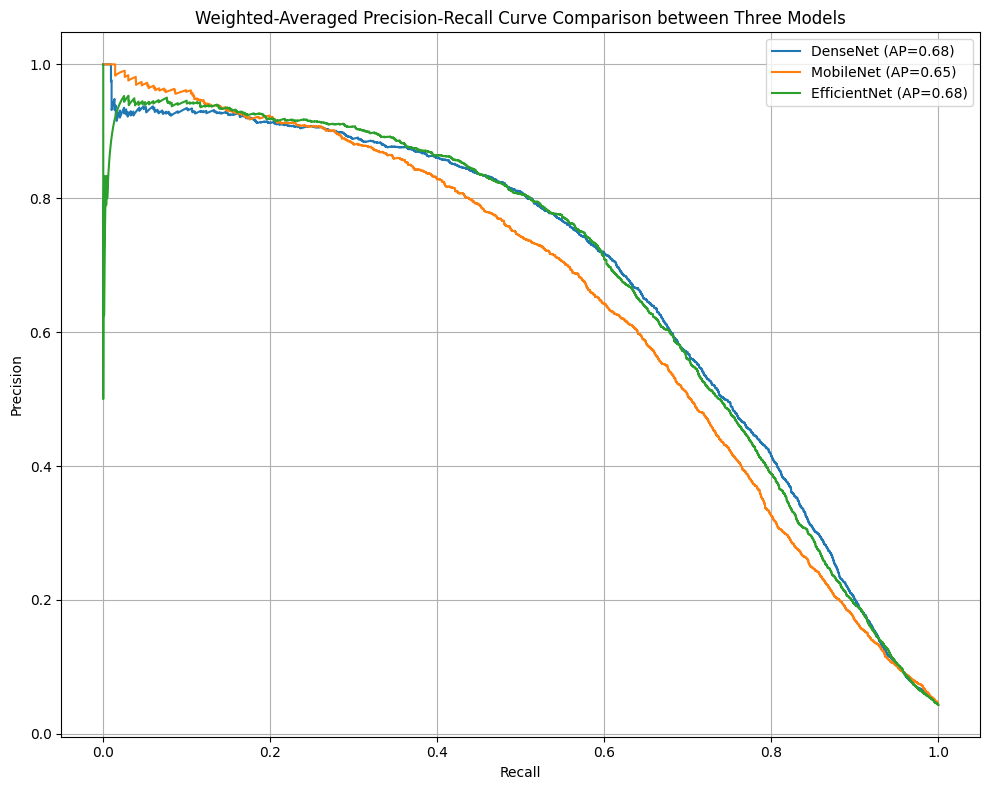

In [50]:
models = {
    "DenseNet": model_densenet,
    "MobileNet": model_mobilenet,
    "EfficientNet": model_efficientnet
}

precision_recall_graph(models, test_loader, class_names, device)


### Evaluation by Confusion Matrix

In [61]:

############################ 
# Coded by Keh Yi Qian, Kok Tze Kang, Gooi Yong Shen together
############################ 

def plot_confusion_matrix(model, test_loader, class_names, device, model_name):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(18, 12))  # Widen the figure
    disp.plot(
        include_values=True,
        cmap=plt.cm.Blues,
        ax=ax,
        xticks_rotation=90,  # Rotate x-axis labels vertically
        values_format='d'
    )
    
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.tight_layout()  # Ensure labels don't get cut off
    plt.show()



### Confusion Matrix of DenseNet Model

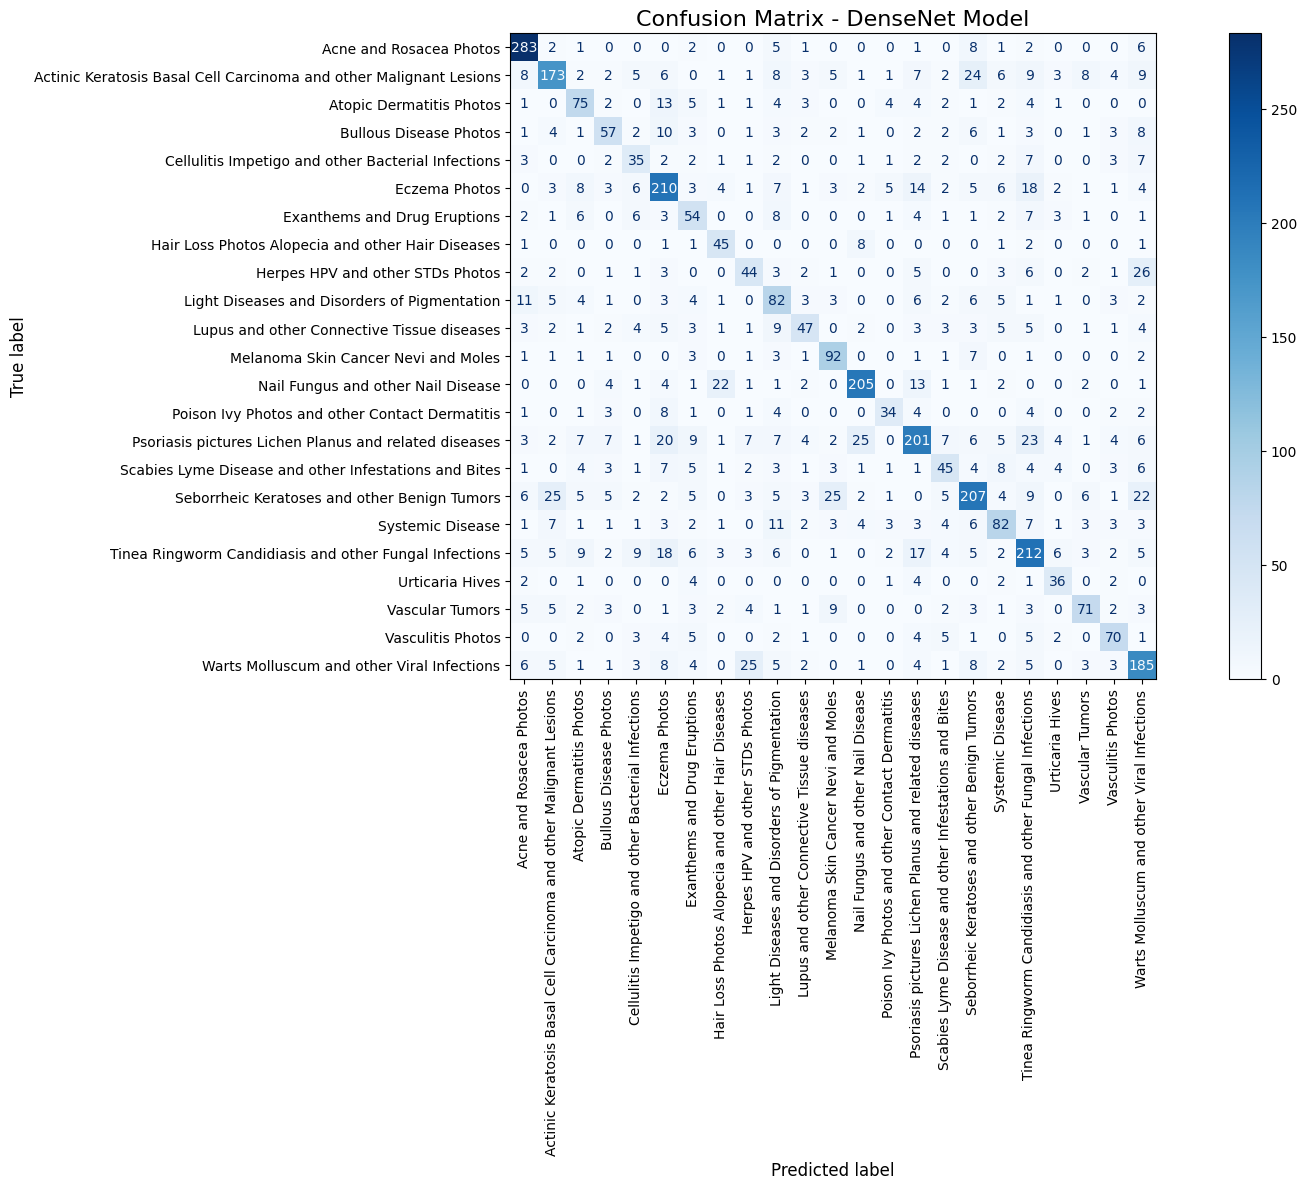

In [62]:
plot_confusion_matrix(model_densenet, test_loader, class_names, device, 'DenseNet Model')

### Confusion Matrix of MobileNet Model

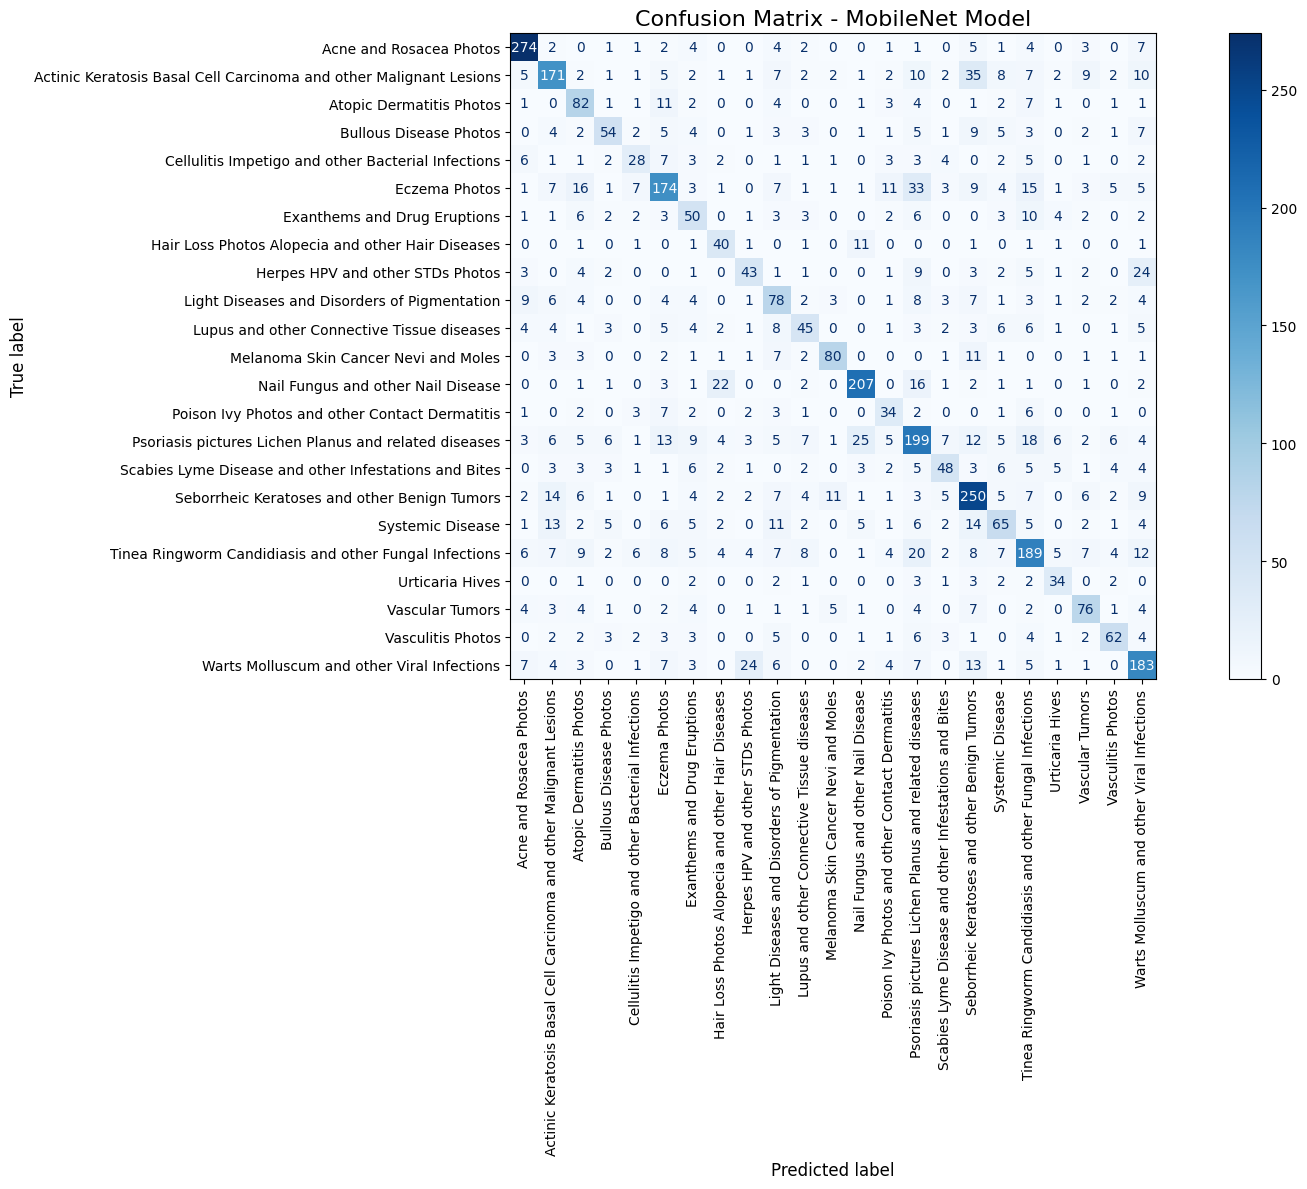

In [64]:
plot_confusion_matrix(model_mobilenet, test_loader, class_names, device, 'MobileNet Model')

### Confusion Matrix of EfficientNet Model

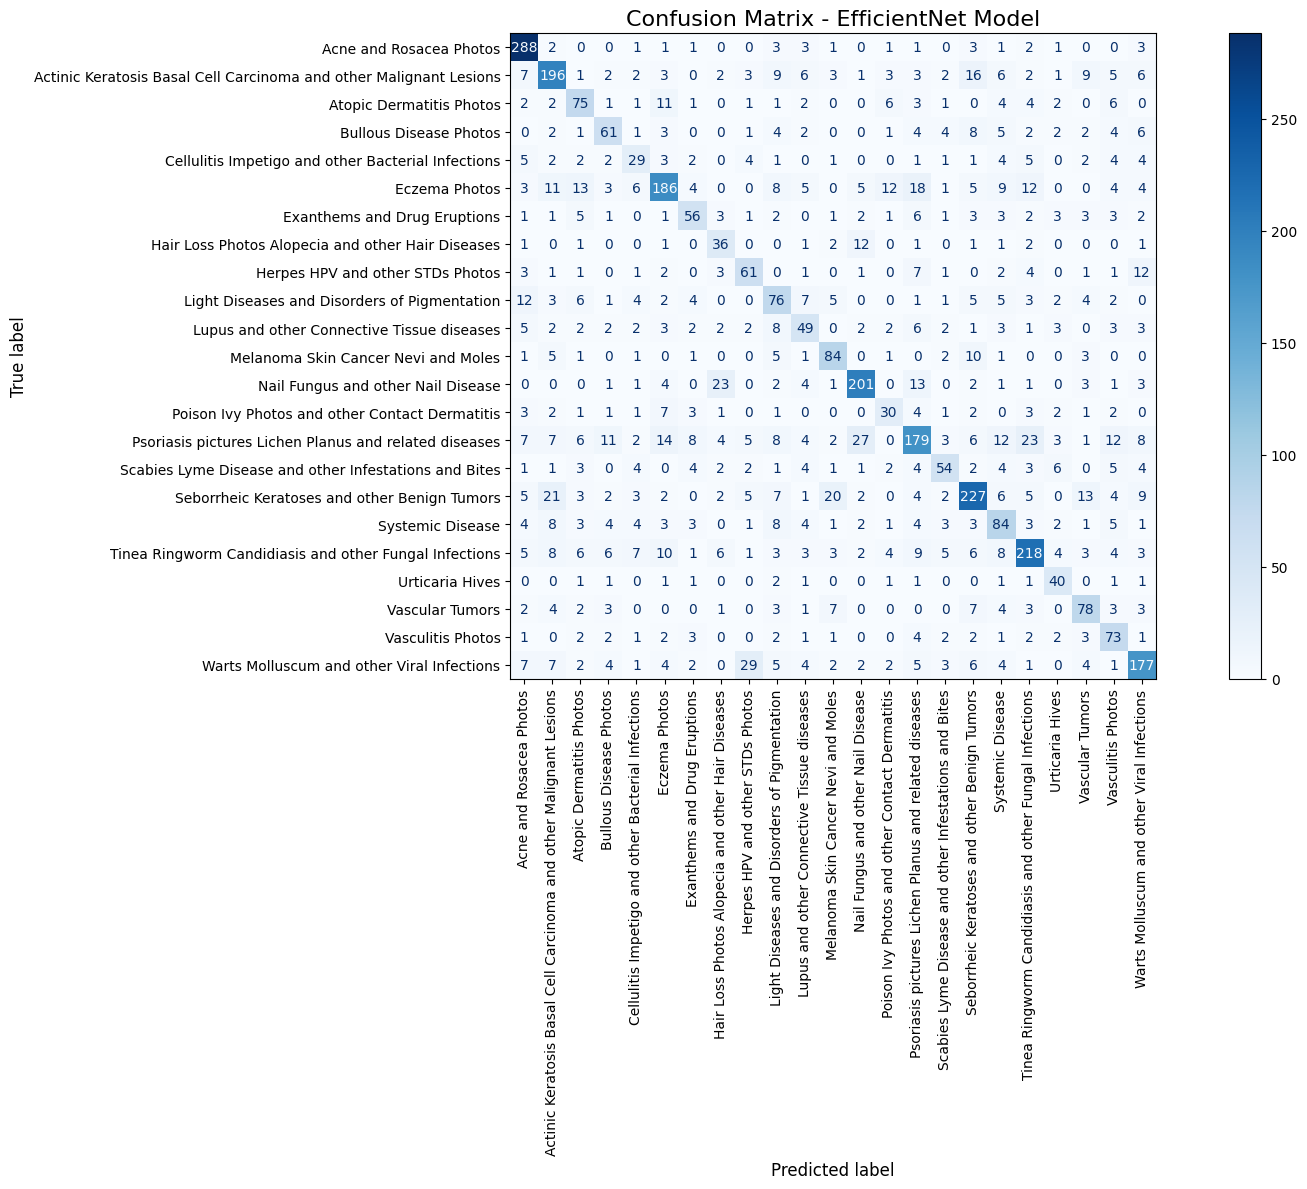

In [66]:
plot_confusion_matrix(model_efficientnet, test_loader, class_names, device, 'EfficientNet Model')

### Chapter 6: Inferences

In [99]:
############################ 
# Coded by Gooi Yong Shen
############################ 

def infer_dataset_image(model, dataset, index: int, class_names: list, device: str) -> Tuple[str, float, str]:
    """
    Performs inference on an image from a dataset
    
    Args:
        model: The model to use for inference
        dataset: The dataset containing images
        index: The index of the image in the dataset
        class_names: List of class names
        device: Device to use for inference ('cuda' or 'cpu')
        
    Returns:
        Tuple of (predicted class name, confidence score, true class name)
    """
    # Get image and true label from dataset
    image, true_label = dataset[index]
    
    # No need to apply transforms as dataset already does this
    # Just add batch dimension and move to device
    input_tensor = image.unsqueeze(0).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).squeeze().cpu().numpy()
        predicted_idx = np.argmax(probs)
    
    return class_names[predicted_idx], probs[predicted_idx], class_names[true_label]

In [100]:
############################ 
# Coded by Gooi Yong Shen
############################ 

def extract_random_images(dataset, num_samples: int = 5) -> List[int]:
    """
    Extracts random image indices from the dataset
    
    Args:
        dataset: The dataset to extract from
        num_samples: Number of random samples to extract
        
    Returns:
        List of random indices
    """
    return random.sample(range(len(dataset)), num_samples)


In [101]:
############################ 
# Coded by Gooi Yong Shen
############################ 

def visualize_and_infer(model, dataset, indices: List[int], class_names: list, device: str):
    """
    Visualizes images and performs inference on them
    
    Args:
        model: The model to use for inference
        dataset: The dataset containing images
        indices: List of indices to visualize and infer
        class_names: List of class names
        device: Device to use for inference ('cuda' or 'cpu')
    """
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 4*len(indices)))
    
    # Handle case with single image
    if len(indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        # Get image and label
        image, label = dataset[idx]
        
        # Convert tensor to numpy for visualization
        img_np = image.permute(1, 2, 0).cpu().numpy()
        
        # Denormalize the image for better visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Perform inference
        pred_class, confidence, true_class = infer_dataset_image(model, dataset, idx, class_names, device)
        
        # Display original image
        axes[i][0].imshow(img_np)
        axes[i][0].set_title(f"Original Image (Index: {idx})")
        axes[i][0].axis('off')
        
        # Display prediction info
        axes[i][1].axis('off')
        axes[i][1].text(0.1, 0.6, f"True Class: {true_class}", fontsize=12)
        axes[i][1].text(0.1, 0.5, f"Predicted: {pred_class}", fontsize=12)
        axes[i][1].text(0.1, 0.4, f"Confidence: {confidence:.4f}", fontsize=12)
        if pred_class == true_class:
            color = 'green'
        else:
            color = 'red'
        axes[i][1].text(0.1, 0.3, f"Result: {'Correct' if pred_class == true_class else 'Incorrect'}", 
                         fontsize=12, color=color)
    
    plt.tight_layout()
    plt.show()
    
    return indices


In [107]:
############################ 
# Coded by Gooi Yong Shen
############################ 

def make_inferences(dataset, num_samples, model_to_inf):
    random_indices = extract_random_images(dataset = dataset, num_samples = num_samples)
    visualize_and_infer(model = model_to_inf, dataset = dataset, indices = random_indices, class_names = class_names, device = device)
    print("\nDetailed Inference Results:")
    for idx in random_indices:
        pred_class, confidence, true_class = infer_dataset_image(model = model_to_inf, dataset = test_dataset, index = idx, class_names = class_names, device = device)
        print(f"Image {idx}: True: {true_class}, Predicted: {pred_class}, Confidence: {confidence:.4f}")

### Inferences of the DenseNet Model

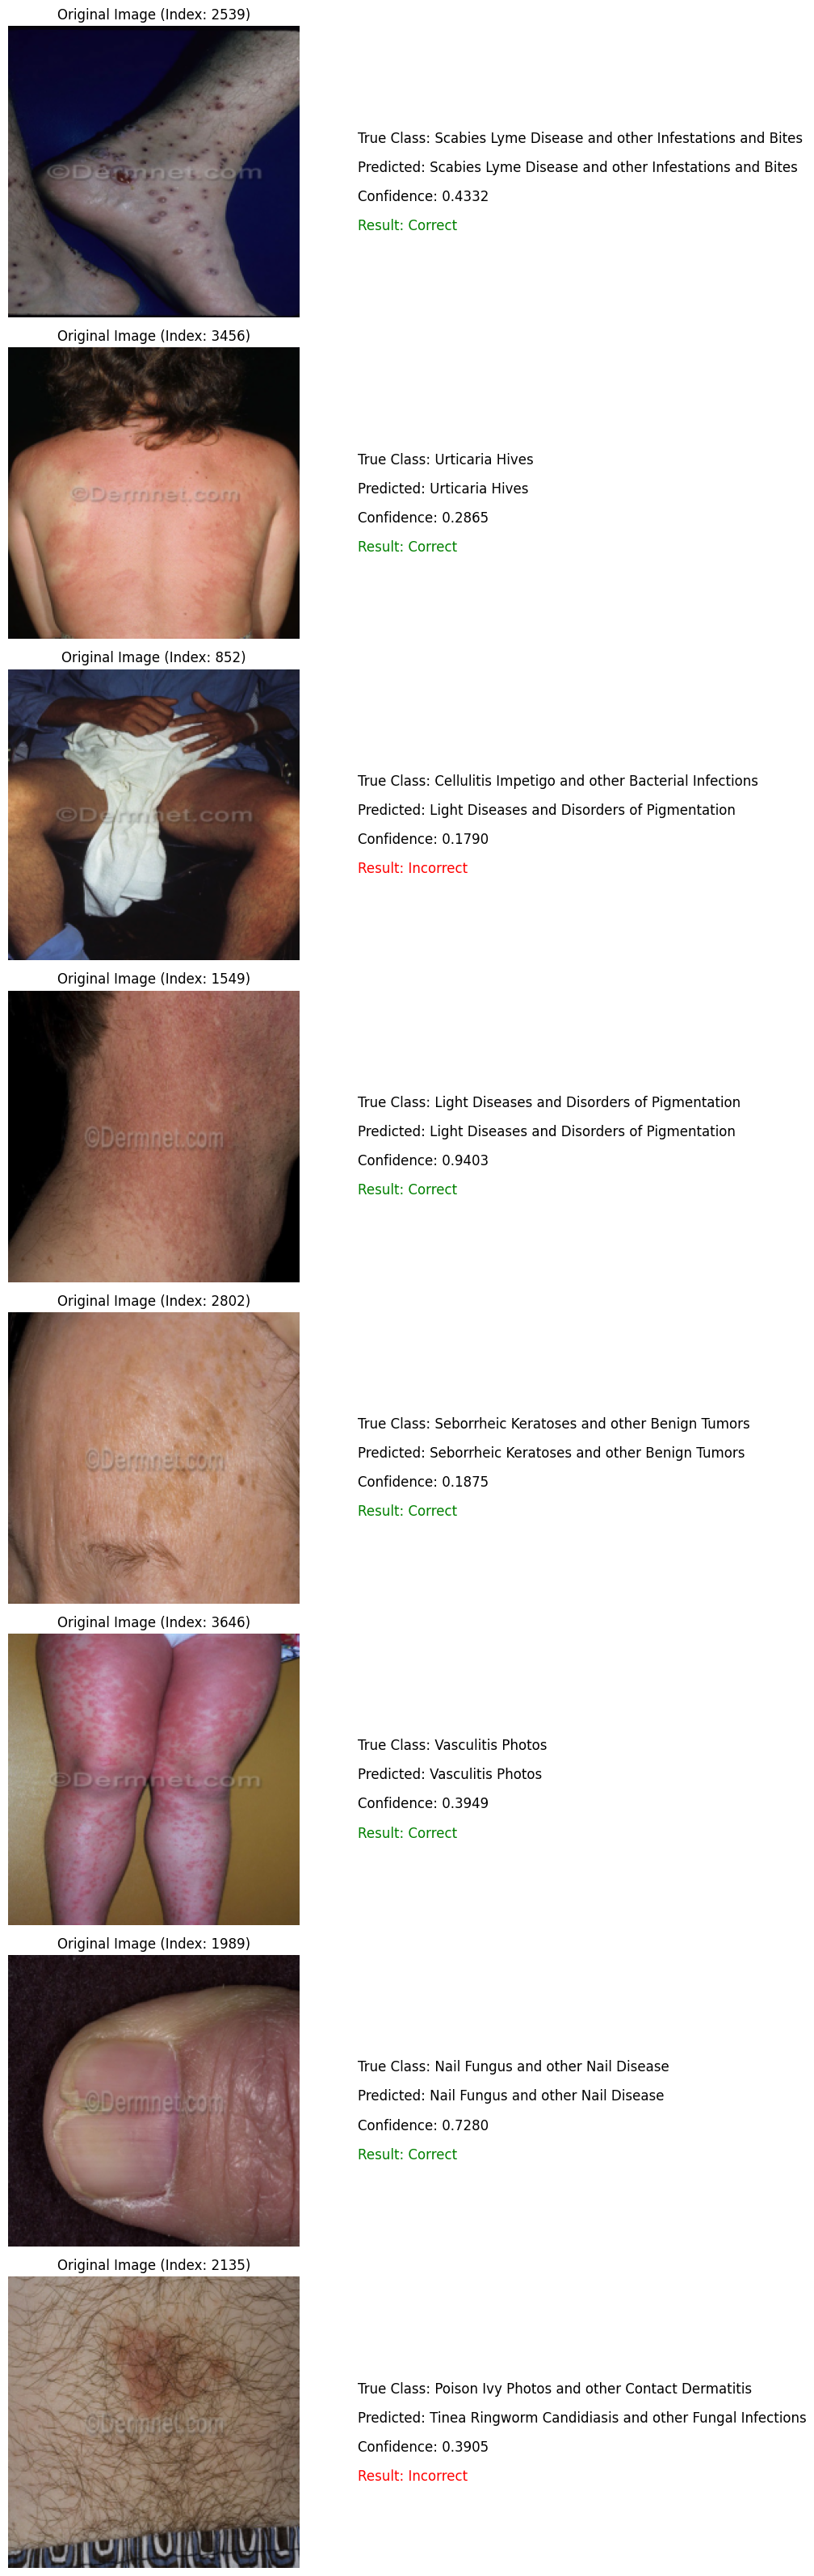


Detailed Inference Results:
Image 2539: True: Scabies Lyme Disease and other Infestations and Bites, Predicted: Scabies Lyme Disease and other Infestations and Bites, Confidence: 0.4332
Image 3456: True: Urticaria Hives, Predicted: Urticaria Hives, Confidence: 0.2865
Image 852: True: Cellulitis Impetigo and other Bacterial Infections, Predicted: Light Diseases and Disorders of Pigmentation, Confidence: 0.1790
Image 1549: True: Light Diseases and Disorders of Pigmentation, Predicted: Light Diseases and Disorders of Pigmentation, Confidence: 0.9403
Image 2802: True: Seborrheic Keratoses and other Benign Tumors, Predicted: Seborrheic Keratoses and other Benign Tumors, Confidence: 0.1875
Image 3646: True: Vasculitis Photos, Predicted: Vasculitis Photos, Confidence: 0.3949
Image 1989: True: Nail Fungus and other Nail Disease, Predicted: Nail Fungus and other Nail Disease, Confidence: 0.7280
Image 2135: True: Poison Ivy Photos and other Contact Dermatitis, Predicted: Tinea Ringworm Candidia

In [108]:
dataset = test_dataset
class_names = class_names
# set how many images you want extract
num_samples = 8
# set which model you want do inference, but make sure to load them first! By default if you execute the evaluation part already, the model is loaded
model_to_inf = model_densenet

make_inferences(dataset, num_samples, model_to_inf)

### Inferences of the MobileNet Model

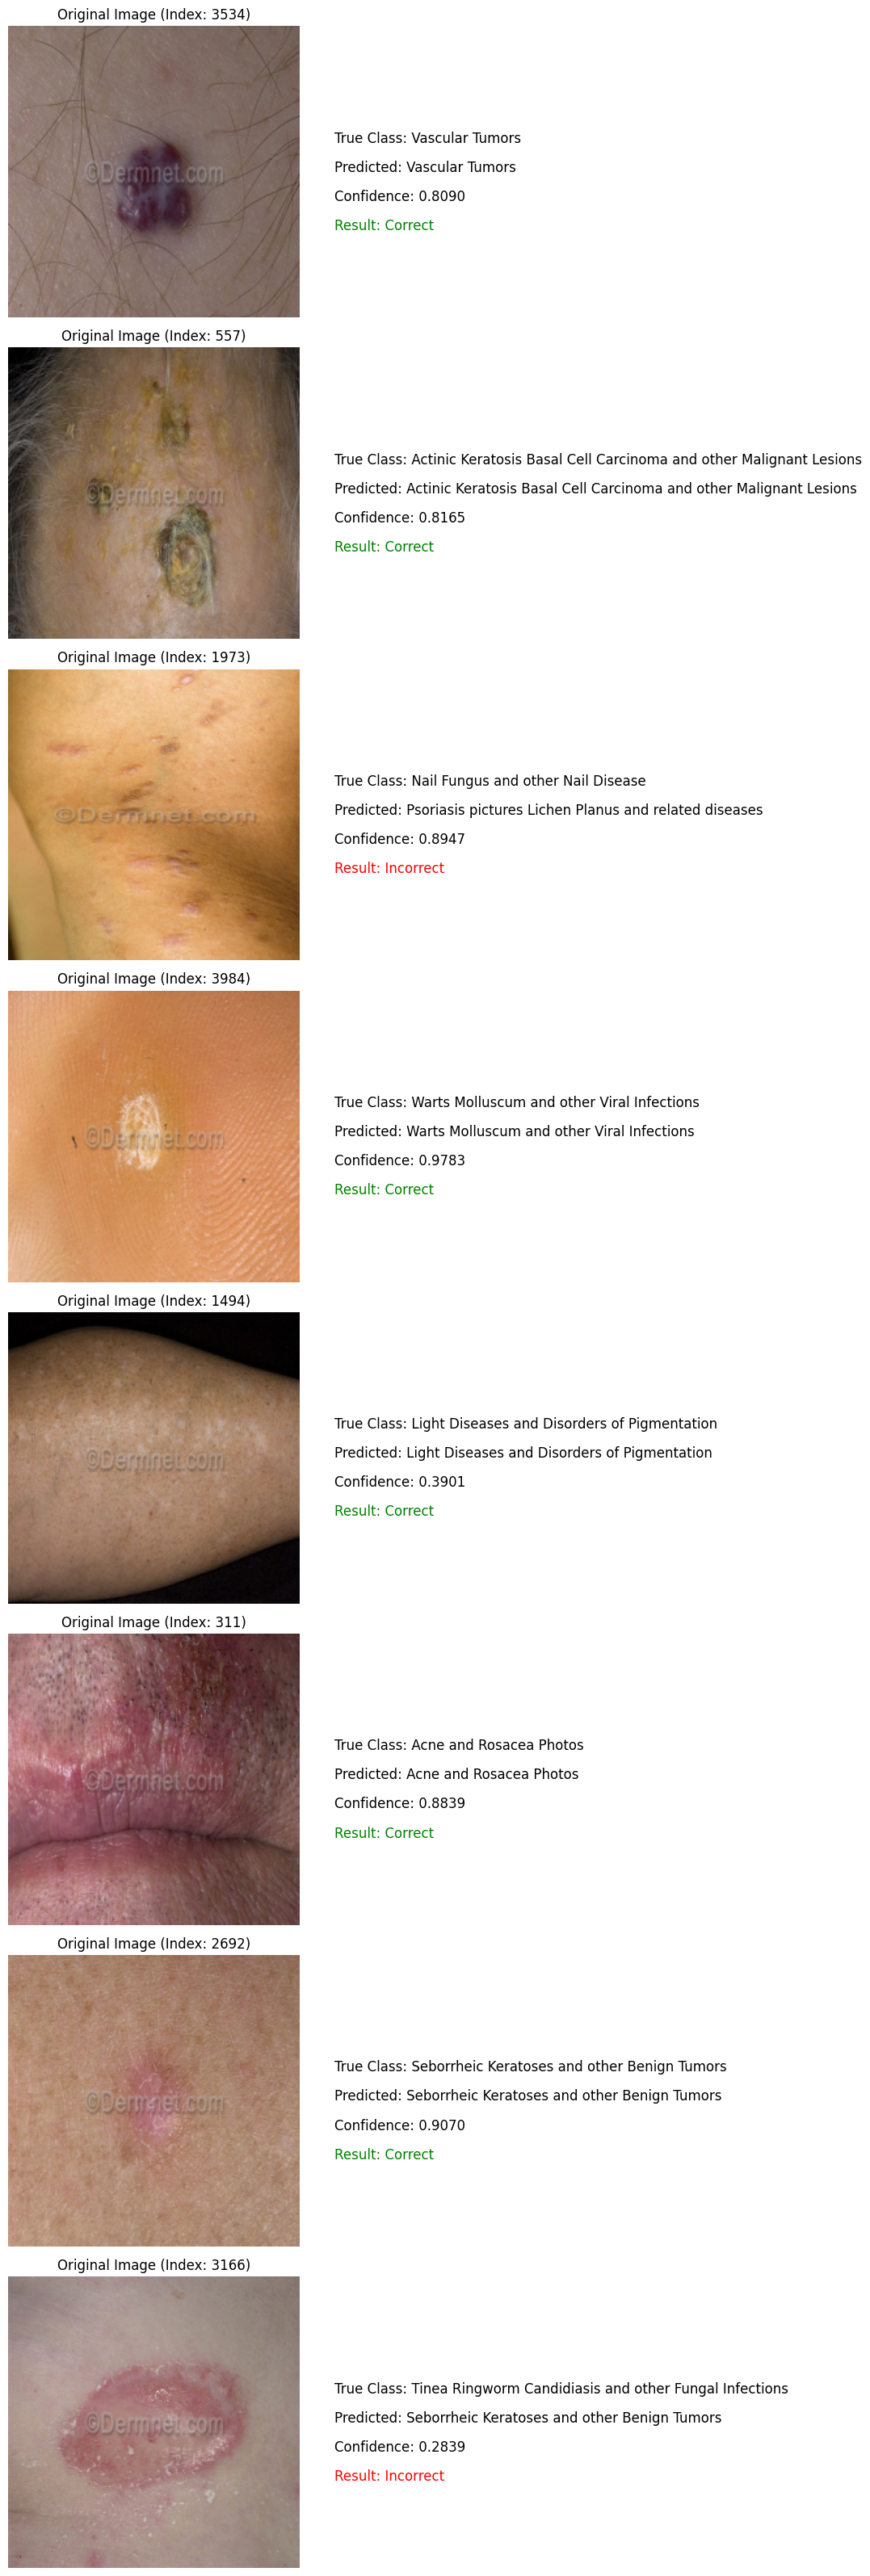


Detailed Inference Results:
Image 3534: True: Vascular Tumors, Predicted: Vascular Tumors, Confidence: 0.8090
Image 557: True: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, Predicted: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, Confidence: 0.8165
Image 1973: True: Nail Fungus and other Nail Disease, Predicted: Psoriasis pictures Lichen Planus and related diseases, Confidence: 0.8947
Image 3984: True: Warts Molluscum and other Viral Infections, Predicted: Warts Molluscum and other Viral Infections, Confidence: 0.9783
Image 1494: True: Light Diseases and Disorders of Pigmentation, Predicted: Light Diseases and Disorders of Pigmentation, Confidence: 0.3901
Image 311: True: Acne and Rosacea Photos, Predicted: Acne and Rosacea Photos, Confidence: 0.8839
Image 2692: True: Seborrheic Keratoses and other Benign Tumors, Predicted: Seborrheic Keratoses and other Benign Tumors, Confidence: 0.9070
Image 3166: True: Tinea Ringworm Candidiasis and other

In [109]:
model_to_inf = model_mobilenet

make_inferences(dataset, num_samples, model_to_inf)

### Inferences of the EfficientNet Model

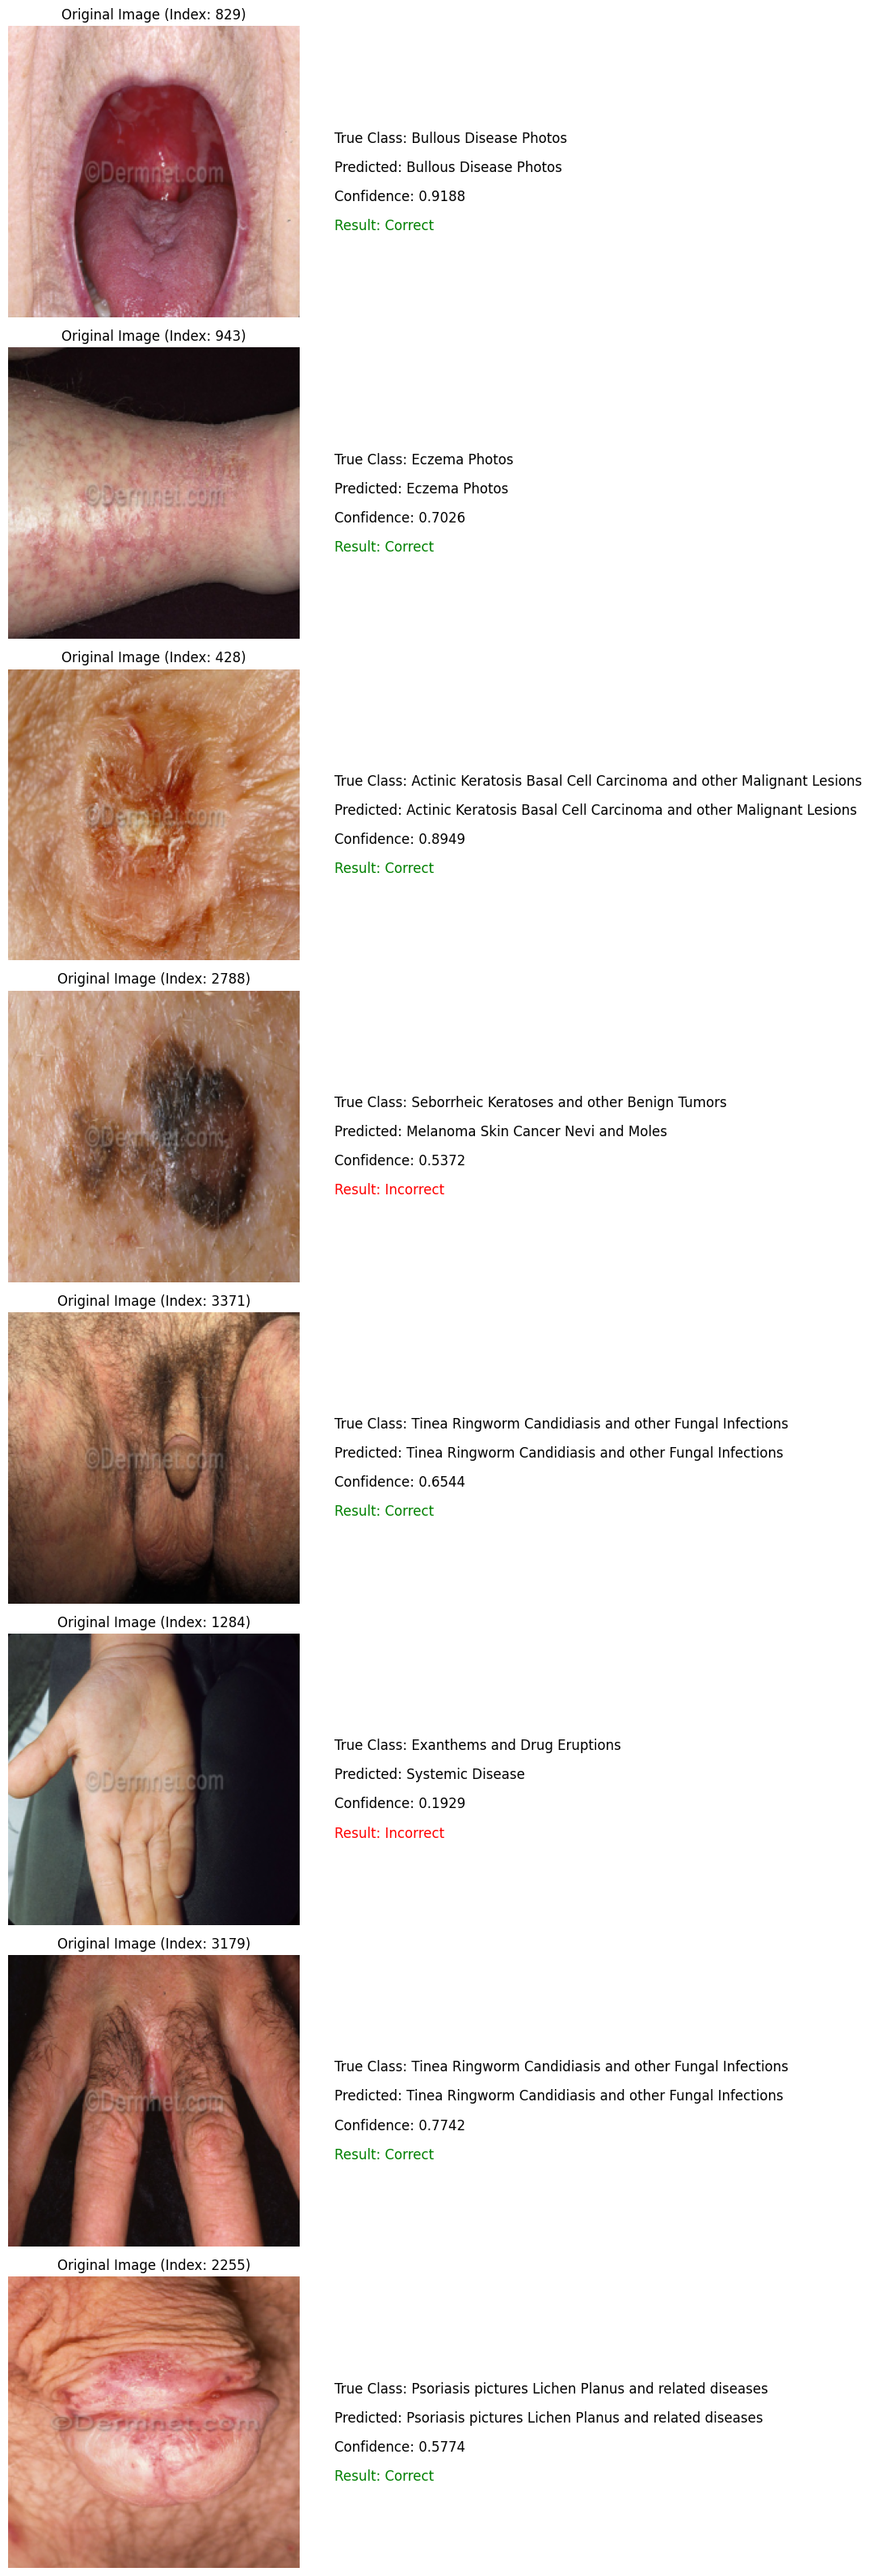


Detailed Inference Results:
Image 829: True: Bullous Disease Photos, Predicted: Bullous Disease Photos, Confidence: 0.9188
Image 943: True: Eczema Photos, Predicted: Eczema Photos, Confidence: 0.7026
Image 428: True: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, Predicted: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, Confidence: 0.8949
Image 2788: True: Seborrheic Keratoses and other Benign Tumors, Predicted: Melanoma Skin Cancer Nevi and Moles, Confidence: 0.5372
Image 3371: True: Tinea Ringworm Candidiasis and other Fungal Infections, Predicted: Tinea Ringworm Candidiasis and other Fungal Infections, Confidence: 0.6544
Image 1284: True: Exanthems and Drug Eruptions, Predicted: Systemic Disease, Confidence: 0.1929
Image 3179: True: Tinea Ringworm Candidiasis and other Fungal Infections, Predicted: Tinea Ringworm Candidiasis and other Fungal Infections, Confidence: 0.7742
Image 2255: True: Psoriasis pictures Lichen Planus and related diseas

In [110]:
model_to_inf = model_efficientnet

make_inferences(dataset, num_samples, model_to_inf)